In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Black-Scholes parameters
K = 50.0
r = 0.05
sigma = 0.2
T = 1.0  # maturity (years)

# Neural network V(S, t)
def create_model():
    return tf.keras.Sequential([
        tf.keras.layers.InputLayer((2,)),  # S, t
        tf.keras.layers.Dense(64, 'tanh'),
        tf.keras.layers.Dense(64, 'tanh'),
        tf.keras.layers.Dense(64, 'tanh'),
        tf.keras.layers.Dense(1, None)
    ])

model = create_model()

# PDE residual loss
def bs_pde_loss(model, S, t):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([S, t])
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch([S, t])
            V = model(tf.concat([S, t], axis=1))
        V_S = tape1.gradient(V, S)
        V_t = tape1.gradient(V, t)
    V_SS = tape2.gradient(V_S, S)
    del tape1, tape2

    pde = V_t + 0.5 * sigma**2 * S**2 * V_SS + r * S * V_S - r * V
    return tf.reduce_mean(tf.square(pde))

# Terminal condition: V(S, T) = max(S - K, 0)
def terminal_loss(model, S):
    t = tf.ones_like(S) * T
    V = model(tf.concat([S, t], axis=1))
    payoff = tf.maximum(S - K, 0)
    return tf.reduce_mean(tf.square(V - payoff))

# Boundary conditions (optional)
def boundary_loss(model):
    S_min = tf.constant([[1e-8]])
    S_max = tf.constant([[5*K]])
    t = tf.linspace(0.0, T, 10)[:, None]

    V_low = model(tf.concat([S_min * tf.ones_like(t), t], axis=1))
    V_high = model(tf.concat([S_max * tf.ones_like(t), t], axis=1))
    bc1 = tf.reduce_mean(tf.square(V_low))  # should be 0
    bc2 = tf.reduce_mean(tf.square(V_high - (S_max - K*tf.exp(-r*(T - t)))))  # asymptotic
    return bc1 + bc2

# Training loop
optimizer = tf.keras.optimizers.Adam(1e-3)

for epoch in range(5000):
    # sample random points
    S = tf.random.uniform((256, 1), 0.0, 2*K)
    t = tf.random.uniform((256, 1), 0.0, T)
    with tf.GradientTape() as tape:
        L_pde = bs_pde_loss(model, S, t)
        L_terminal = terminal_loss(model, tf.random.uniform((256, 1), 0.0, 2*K))
        L_boundary = boundary_loss(model)
        loss = L_pde + L_terminal + L_boundary
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: loss={loss.numpy():.6f}")

Epoch 0: loss=41131.082031
Epoch 500: loss=25336.412109
Epoch 1000: loss=16987.646484
Epoch 1500: loss=10850.810547
Epoch 2000: loss=6493.479492
Epoch 2500: loss=3563.739014
Epoch 3000: loss=1741.078979
Epoch 3500: loss=726.676331
Epoch 4000: loss=245.444748
Epoch 4500: loss=62.612865


/var/folders/tr/w3stjb6j0pg_svqnfxtymf0w0000gn/T/ipykernel_4434/3322211131.py:5: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / K) + (r + 0.5*sigma**2)*tau) / (sigma*np.sqrt(tau))


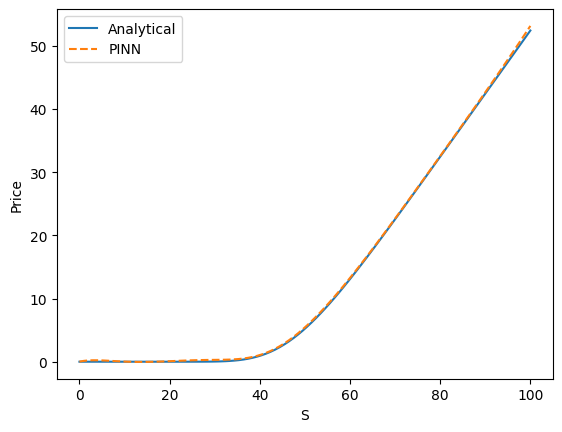

In [3]:
from scipy.stats import norm

def bs_price(S, K, T, t, r, sigma):
    tau = T - t
    d1 = (np.log(S / K) + (r + 0.5*sigma**2)*tau) / (sigma*np.sqrt(tau))
    d2 = d1 - sigma*np.sqrt(tau)
    return S*norm.cdf(d1) - K*np.exp(-r*tau)*norm.cdf(d2)

S_vals = np.linspace(0.0, 2*K, 100)[:, None]
t_vals = np.zeros_like(S_vals)
V_pred = model(tf.concat([S_vals, t_vals], axis=1)).numpy().flatten()
V_true = bs_price(S_vals.flatten(), K, T, 0.0, r, sigma)

plt.plot(S_vals, V_true, label='Analytical')
plt.plot(S_vals, V_pred, '--', label='PINN')
plt.legend(); plt.xlabel('S'); plt.ylabel('Price'); plt.show()
